<a href="https://colab.research.google.com/github/WestChaeVI/My-First-Project/blob/main/Neural_Style_Transfer_For_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://deep-learning-study.tistory.com/679 Coding with reference to this link.

In [1]:
# Create a folder to store data
!mkdir data

mkdir: cannot create directory ‘data’: File exists


# Loading Image Data

It is a way to link Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/data

/content/data


# Import pictures from Google Drive.

In [4]:
# Load Image for content and style
from PIL import Image
path2content = '/content/drive/MyDrive/Colab Notebooks/my puppy.jpg'
path2style = '/content/drive/MyDrive/Colab Notebooks/st.jpg'

content_img = Image.open(path2content)
style_img = Image.open(path2style)

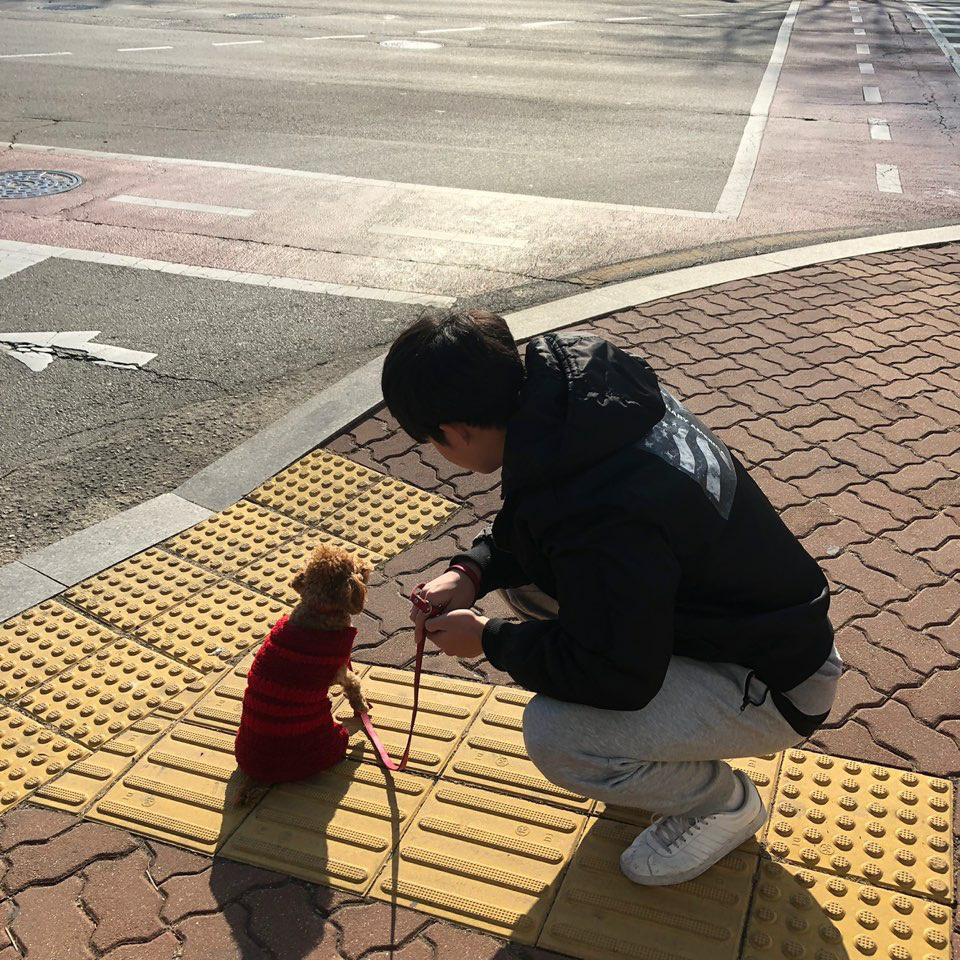

In [5]:
# Check content image
content_img

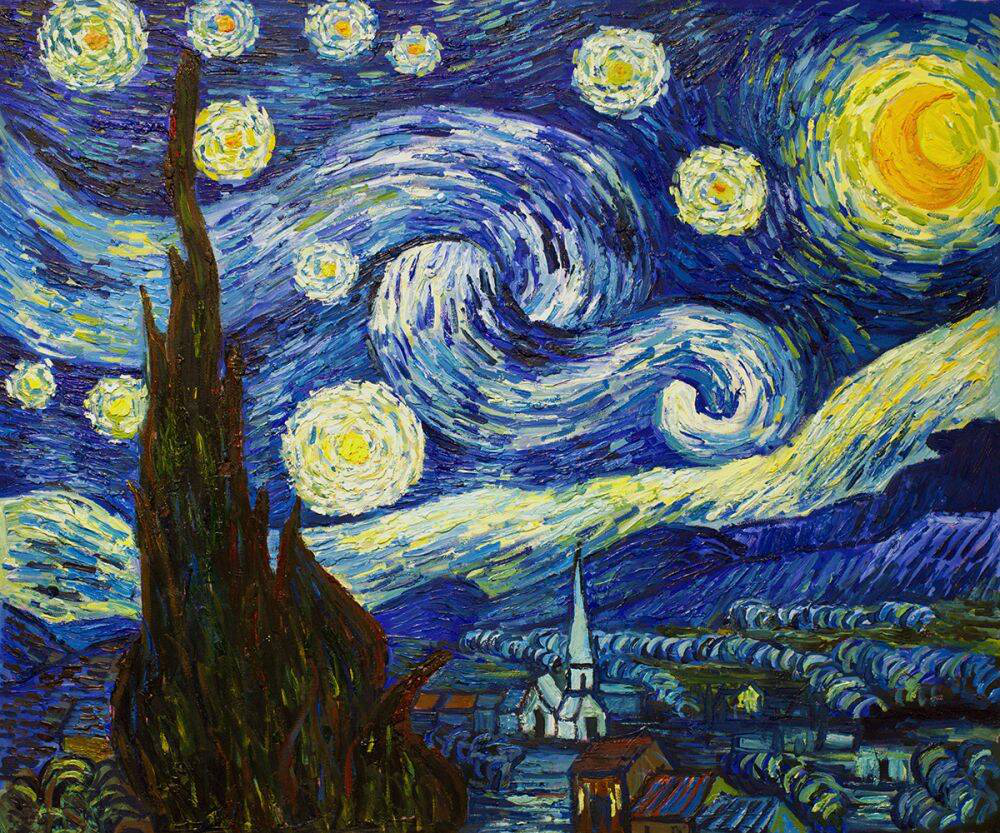

In [6]:
# Check style image
style_img

# Applying Transformation

In [7]:
import torchvision.transforms as transforms

h, w = 256, 384
mean_rgb = (0.485, 0.456, 0.406)
std_rgb = (0.229, 0.224, 0.225)

transformer = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.ToTensor(),
                transforms.Normalize(mean_rgb, std_rgb)
])

In [8]:
# Applying transformation to an image
content_tensor = transformer(content_img)
style_tensor = transformer(style_img)
print(content_tensor.shape, content_tensor.requires_grad)
print(style_tensor.shape, style_tensor.requires_grad)

torch.Size([3, 256, 384]) False
torch.Size([3, 256, 384]) False


It is recommended that the uploaded photo be an RGB photo with a channel number of 3, rather than a cmyk with a channel number of 4, if possible.
for example, If output is 'torch.Size([4, 256, 384]) False', I will look for other pictures more. 

In [9]:
# Visualizing an image with transformation
import torch

def imgtensor2pil(img_tensor):
    img_tensor_c = img_tensor.clone().detach()
    img_tensor_c *= torch.tensor(std_rgb).view(3, 1,1)
    img_tensor_c += torch.tensor(mean_rgb).view(3,1,1)
    img_tensor_c = img_tensor_c.clamp(0,1)
    img_pil = to_pil_image(img_tensor_c)
    return img_pil

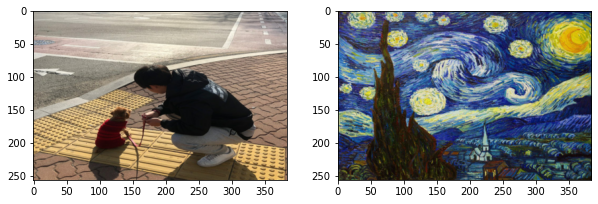

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.transforms.functional import to_pil_image

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(imgtensor2pil(content_tensor))
plt.subplot(1,2,2)
plt.imshow(imgtensor2pil(style_tensor))

# Implementing Style Transfer

In [11]:
# loading pretrained VGG19
import torchvision.models as models
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vgg = models.vgg19(pretrained=True).to(device).eval()
# model_vgg.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True).to(device)

# state_dict_path='/content/drive/MyDrive/프로젝트/project1/best_model_vgg19.pt'
# weights = torch.load(state_dict_path)
# # definc model : weights are randomly initiated
# model_vgg.load_state_dict(weights['net'])

# Freezing parameter.
for param in model_vgg.parameters():
    param.requires_grad_(False)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
model_vgg = model_vgg.features.to(device)

In [13]:
model_vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# Defining Loss Function

In [14]:
# In order to define style loss and content loss
# the Gram matrix must be calculated after obtaining the intermediate feature of the model.

# Defines the function that obtains the output value of the middle layer of the model.
def get_features(x, model, layers):
    features = {}
    for name, layer in enumerate(model.children()): # 0, conv
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
    return features

In [15]:
# Defines a function that calculates the Gram matrix.
def gram_matrix(x):
    n, c, h, w = x.size()
    x = x.view(n*c, h*w)
    gram = torch.mm(x,x.t()) # Performing inter-matrix multiplication
    return gram

In [16]:
# Defines a function that calculates the content loss.
import torch.nn.functional as F

def get_content_loss(pred_features, target_features, layer):
    target = target_features[layer]
    pred = pred_features[layer]
    loss = F.mse_loss(pred, target)
    return loss

In [17]:
# style loss
def get_style_loss(pred_features, target_features, style_layers_dict):
    loss = 0
    for layer in style_layers_dict:
        pred_fea = pred_features[layer]
        pred_gram = gram_matrix(pred_fea)
        n, c, h, w = pred_fea.shape
        target_gram = gram_matrix(target_features[layer])
        layer_loss = style_layers_dict[layer] * F.mse_loss(pred_gram, target_gram)
        loss += layer_loss / (n*c*h*w)
    return loss

In [18]:
# Get feature for content and style image.
feature_layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}

con_tensor = content_tensor.unsqueeze(0).to(device)
sty_tensor = style_tensor.unsqueeze(0).to(device)

content_features = get_features(con_tensor, model_vgg, feature_layers)
style_features = get_features(sty_tensor, model_vgg, feature_layers)

In [19]:
# Checking content feature.
for key in content_features.keys():
    print(content_features[key].shape)

torch.Size([1, 64, 256, 384])
torch.Size([1, 128, 128, 192])
torch.Size([1, 256, 64, 96])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 16, 24])


# Defining Optimizer

In [20]:
# Create the input tensor from which you copied the content tensor.
input_tensor = con_tensor.clone().requires_grad_(True)

# Define Optimizer.
from torch import optim
optimizer = optim.Adam([input_tensor], lr=0.01)

# Let's train

In [21]:
# Define Hyper-Parameter
num_epochs = 5000
content_weight = 1e1
style_weight = 30*1e4
content_layer = 'conv5_1'
style_layers_dict = {'conv1_1':0.75,
                     'conv2_1':0.5,
                     'conv3_1':0.25,
                     'conv4_1':0.25,
                     'conv5_1':0.25}

In [22]:
# style transfer
for epoch in range(num_epochs+1):
    optimizer.zero_grad()
    input_features = get_features(input_tensor, model_vgg, feature_layers) # feature_layers에 해당하는 layer의 출력값 얻기
    content_loss = get_content_loss(input_features, content_features, content_layer) # 
    style_loss = get_style_loss(input_features, style_features, style_layers_dict)
    neural_loss = content_weight * content_loss + style_weight * style_loss
    neural_loss.backward(retain_graph=True)
    optimizer.step()
    # if style_loss <= 0.12:
    #   break
    if epoch % 100 == 0:
        print('epoch {}, content loss: {:.2}, style loss: {:.2}'.format(epoch, content_loss, style_loss))

epoch 0, content loss: 0.0, style loss: 2.4e+02
epoch 100, content loss: 3.8, style loss: 2.4e+01
epoch 200, content loss: 4.2, style loss: 4.7
epoch 300, content loss: 4.4, style loss: 2.3
epoch 400, content loss: 4.5, style loss: 1.7
epoch 500, content loss: 4.6, style loss: 1.4
epoch 600, content loss: 4.6, style loss: 1.2
epoch 700, content loss: 4.7, style loss: 1.1
epoch 800, content loss: 4.7, style loss: 0.94
epoch 900, content loss: 4.8, style loss: 0.84
epoch 1000, content loss: 4.8, style loss: 0.76
epoch 1100, content loss: 4.8, style loss: 0.69
epoch 1200, content loss: 4.9, style loss: 0.63
epoch 1300, content loss: 4.9, style loss: 0.58
epoch 1400, content loss: 4.9, style loss: 0.54
epoch 1500, content loss: 4.9, style loss: 0.5
epoch 1600, content loss: 4.9, style loss: 0.46
epoch 1700, content loss: 4.9, style loss: 0.44
epoch 1800, content loss: 4.9, style loss: 0.41
epoch 1900, content loss: 4.9, style loss: 0.39
epoch 2000, content loss: 5.0, style loss: 0.36
epoch

In [23]:
import cv2

img = cv2.imread(path2content)

print(type(img))
print('원본 이미지 사이즈:',img.shape)
print(type(img.shape))

<class 'numpy.ndarray'>
원본 이미지 사이즈: (960, 960, 3)
<class 'tuple'>


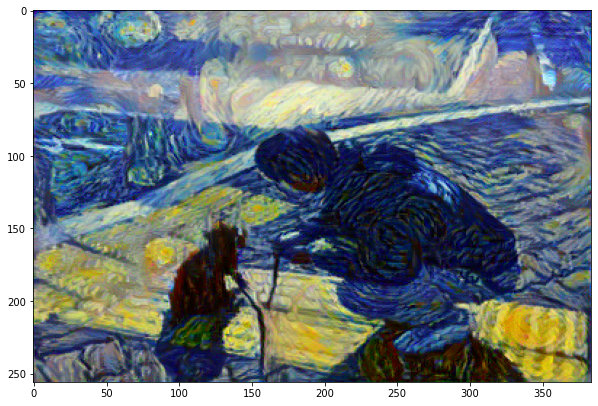

In [24]:
# Visualization the result
plt.figure(figsize=(10,10))
plt.imshow(imgtensor2pil(input_tensor[0].cpu()))


# Save the picture to Google Drive

In [25]:
output_img = imgtensor2pil(input_tensor[0].cpu())
output_img.save('/content/drive/MyDrive/Colab Notebooks/Starry_Puppy.png', 'png')

output_img.save('The path you will save inside Google Drive/new_name.png', 'png')

Go to the path you set and look for it. There will be a new picture.